In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [9]:
import pandas as pd

# 불러오기
df_fund = pd.read_csv("fundamental_revision.csv")
df_tech = pd.read_csv("technical_indicators_kospi200.csv")
df_vol = pd.read_csv("volume_factor.csv")

# 각 상위 3개 행과 칼럼 확인
print("펀더멘털:", df_fund.columns.tolist())
print(df_fund.head(3))

print("\n기술적지표:", df_tech.columns.tolist())
print(df_tech.head(3))

print("\n거래량지표:", df_vol.columns.tolist())
print(df_vol.head(3))

/tmp/ipython-input-9-3151757178.py:4: DtypeWarning: Columns (691,1065,1066,1635,1636,1911,1916) have mixed types. Specify dtype option on import or set low_memory=False.
  df_fund = pd.read_csv("fundamental_revision.csv")


펀더멘털: ['Symbol_SymbolName_ItemName', 'A005930_삼성전자_부채비율(%)', 'A005930_삼성전자_PER(배)', 'A005930_삼성전자_PBR(배)', 'A005930_삼성전자_PSR(배)', 'A005930_삼성전자_ROA(영업이익)(%)', 'A005930_삼성전자_ROE(당기순이익)(%)', 'A005930_삼성전자_영업이익률(%)', 'A005930_삼성전자_매출액증가율(전분기)(%)', 'A005930_삼성전자_당기순이익증가율(전분기)(%)', 'A005930_삼성전자_현금흐름/영업수익(%)', 'A000660_SK하이닉스_부채비율(%)', 'A000660_SK하이닉스_PER(배)', 'A000660_SK하이닉스_PBR(배)', 'A000660_SK하이닉스_PSR(배)', 'A000660_SK하이닉스_ROA(영업이익)(%)', 'A000660_SK하이닉스_ROE(당기순이익)(%)', 'A000660_SK하이닉스_영업이익률(%)', 'A000660_SK하이닉스_매출액증가율(전분기)(%)', 'A000660_SK하이닉스_당기순이익증가율(전분기)(%)', 'A000660_SK하이닉스_현금흐름/영업수익(%)', 'A207940_삼성바이오로직스_부채비율(%)', 'A207940_삼성바이오로직스_PER(배)', 'A207940_삼성바이오로직스_PBR(배)', 'A207940_삼성바이오로직스_PSR(배)', 'A207940_삼성바이오로직스_ROA(영업이익)(%)', 'A207940_삼성바이오로직스_ROE(당기순이익)(%)', 'A207940_삼성바이오로직스_영업이익률(%)', 'A207940_삼성바이오로직스_매출액증가율(전분기)(%)', 'A207940_삼성바이오로직스_당기순이익증가율(전분기)(%)', 'A207940_삼성바이오로직스_현금흐름/영업수익(%)', 'A373220_LG에너지솔루션_부채비율(%)', 'A373220_LG에너지솔루션_PER(배)', 'A373220_LG에너지솔루션_PBR(배)', 'A373220_LG

In [13]:
# 대강 추측하지 않고 정확히 설정
df_tech.rename(columns={df_tech.columns[0]: "date"}, inplace=True)
df_tech["date"] = pd.to_datetime(df_tech["date"])

In [14]:
print(df_tech.columns.tolist())

['date', 'a005930_ret_5d', 'a005930_ret_10d', 'a005930_ret_20d', 'a005930_ret_60d', 'a005930_disparity_5d', 'a005930_disparity_10d', 'a005930_disparity_20d', 'a005930_disparity_60d', 'a005930_macd', 'a005930_rsi', 'a005930_willr', 'a005930_hist_vol', 'a005930_garch_vol', 'a005930_volume_ma_ratio', 'a005930_volume_spike_ratio', 'a000660_ret_5d', 'a000660_ret_10d', 'a000660_ret_20d', 'a000660_ret_60d', 'a000660_disparity_5d', 'a000660_disparity_10d', 'a000660_disparity_20d', 'a000660_disparity_60d', 'a000660_macd', 'a000660_rsi', 'a000660_willr', 'a000660_hist_vol', 'a000660_garch_vol', 'a000660_volume_ma_ratio', 'a000660_volume_spike_ratio', 'a207940_ret_5d', 'a207940_ret_10d', 'a207940_ret_20d', 'a207940_ret_60d', 'a207940_disparity_5d', 'a207940_disparity_10d', 'a207940_disparity_20d', 'a207940_disparity_60d', 'a207940_macd', 'a207940_rsi', 'a207940_willr', 'a207940_hist_vol', 'a207940_garch_vol', 'a207940_volume_ma_ratio', 'a207940_volume_spike_ratio', 'a373220_ret_5d', 'a373220_ret_

In [21]:
# 2. 대상 컬럼 추출
factor_cols = [col for col in df_tech.columns if col != "date"]

# 3. 각 컬럼별로: 첫 유효값 찾고, 그 값으로 앞부분까지 전부 채우기
for col in factor_cols:
    first_valid_idx = df_tech[col].first_valid_index()
    if first_valid_idx is not None:
        first_valid_value = df_tech.loc[first_valid_idx, col]
        # 앞부분 모두 채우기
        df_tech.loc[:first_valid_idx, col] = first_valid_value
        # 뒷부분 ffill
        df_tech[col] = df_tech[col].ffill()

# 4. 결과 저장
df_tech.to_csv("technical_indicators_filled.csv", index=False)

In [25]:
df_tech.isnull().sum()

,0
date,0
a005930_ret_5d,0
a005930_ret_10d,0
a005930_ret_20d,0
a005930_ret_60d,0
...,...
a002710_willr,0
a002710_hist_vol,0
a002710_garch_vol,731
a002710_volume_ma_ratio,0


In [24]:
mean_val = df_tech["a002710_garch_vol"].mean(skipna=True)
df_tech["a002710_garch_vol"] = df_tech["a002710_garch_vol"].fillna(mean_val)

In [26]:
# "garch_vol"이라는 문자열이 포함된 열 이름 필터링
garch_cols = [col for col in df_tech.columns if "garch_vol" in col]

# 해당 열들 삭제
df_tech.drop(columns=garch_cols, inplace=True)

In [28]:
df_tech.isnull().sum()

,0
date,0
a005930_ret_5d,0
a005930_ret_10d,0
a005930_ret_20d,0
a005930_ret_60d,0
...,...
a002710_rsi,0
a002710_willr,0
a002710_hist_vol,0
a002710_volume_ma_ratio,0


In [29]:
df_tech.to_csv('technical_factor.csv')

In [32]:
print(df_vol.isnull().sum())
print(df_fund.isnull().sum())

date                       0
A000080_하이트진로_기관개인매수강도차    0
A000080_하이트진로_매수매도비율       0
A000080_하이트진로_순매수거래비중      0
A000080_하이트진로_순매수비율        0
                          ..
A489790_한화비전_매수매도비율        0
A489790_한화비전_순매수거래비중       0
A489790_한화비전_순매수비율         0
A489790_한화비전_융자잔고비중        0
A489790_한화비전_차입공매도비중       0
Length: 1015, dtype: int64
Symbol_SymbolName_ItemName           0
A005930_삼성전자_부채비율(%)               128
A005930_삼성전자_PER(배)                  0
A005930_삼성전자_PBR(배)                  0
A005930_삼성전자_PSR(배)                  0
                                  ... 
A002710_TCC스틸_ROE(당기순이익)(%)        128
A002710_TCC스틸_영업이익률(%)             128
A002710_TCC스틸_매출액증가율(전분기)(%)      1694
A002710_TCC스틸_당기순이익증가율(전분기)(%)    1694
A002710_TCC스틸_현금흐름/영업수익(%)         128
Length: 2001, dtype: int64


In [33]:
df_fund.head()

,Symbol_SymbolName_ItemName,A005930_삼성전자_부채비율(%),A005930_삼성전자_PER(배),A005930_삼성전자_PBR(배),A005930_삼성전자_PSR(배),A005930_삼성전자_ROA(영업이익)(%),A005930_삼성전자_ROE(당기순이익)(%),A005930_삼성전자_영업이익률(%),A005930_삼성전자_매출액증가율(전분기)(%),A005930_삼성전자_당기순이익증가율(전분기)(%),...,A002710_TCC스틸_부채비율(%),A002710_TCC스틸_PER(배),A002710_TCC스틸_PBR(배),A002710_TCC스틸_PSR(배),A002710_TCC스틸_ROA(영업이익)(%),A002710_TCC스틸_ROE(당기순이익)(%),A002710_TCC스틸_영업이익률(%),A002710_TCC스틸_매출액증가율(전분기)(%),A002710_TCC스틸_당기순이익증가율(전분기)(%),A002710_TCC스틸_현금흐름/영업수익(%)
0,2019-01-01,34.12,12.22393,1.03123,1.14095,8.03,8.51,12.05,NaN,NaN,...,168.92,8.85504,0.37047,0.10221,4.15,4.4,2.94,NaN,NaN,2.62
1,2019-01-02,34.12,12.23973,1.03256,1.14243,8.03,8.51,12.05,NaN,NaN,...,168.92,8.81077,0.36862,0.10170,4.15,4.4,2.94,NaN,NaN,2.62
2,2019-01-03,34.12,11.87648,1.00192,1.10852,8.03,8.51,12.05,NaN,NaN,...,168.92,8.76649,0.36676,0.10119,4.15,4.4,2.94,NaN,NaN,2.62
3,2019-01-04,34.12,11.82910,0.99792,1.10410,8.03,8.51,12.05,NaN,NaN,...,168.92,8.56725,0.35843,0.09889,4.15,4.4,2.94,NaN,NaN,2.62
4,2019-01-07,34.12,12.23973,1.03256,1.14243,8.03,8.51,12.05,NaN,NaN,...,168.92,8.61153,0.36028,0.09940,4.15,4.4,2.94,NaN,NaN,2.62


In [36]:
df_fund.rename(columns={df_fund.columns[0]: "date"}, inplace=True)
df_fund["date"] = pd.to_datetime(df_fund["date"])

# 2. 컬럼 리스트 (date 제외)
factor_cols = [col for col in df_fund.columns if col != "date"]

# 3. 각 열별로: 최초 유효값 있으면, 그 값으로 앞부분 전부 채우고 이후 ffill
for col in factor_cols:
    first_valid_idx = df_fund[col].first_valid_index()
    if first_valid_idx is not None:
        first_val = df_fund.loc[first_valid_idx, col]
        # 앞부분 모두 (처음부터) 최초 유효값으로 채움
        df_fund.loc[:first_valid_idx - 1, col] = first_val
        # 이후는 일반 ffill
        df_fund[col] = df_fund[col].ffill()

In [37]:
df_fund

,date,A005930_삼성전자_부채비율(%),A005930_삼성전자_PER(배),A005930_삼성전자_PBR(배),A005930_삼성전자_PSR(배),A005930_삼성전자_ROA(영업이익)(%),A005930_삼성전자_ROE(당기순이익)(%),A005930_삼성전자_영업이익률(%),A005930_삼성전자_매출액증가율(전분기)(%),A005930_삼성전자_당기순이익증가율(전분기)(%),...,A002710_TCC스틸_부채비율(%),A002710_TCC스틸_PER(배),A002710_TCC스틸_PBR(배),A002710_TCC스틸_PSR(배),A002710_TCC스틸_ROA(영업이익)(%),A002710_TCC스틸_ROE(당기순이익)(%),A002710_TCC스틸_영업이익률(%),A002710_TCC스틸_매출액증가율(전분기)(%),A002710_TCC스틸_당기순이익증가율(전분기)(%),A002710_TCC스틸_현금흐름/영업수익(%)
0,2019-01-01,34.12,12.22393,1.03123,1.14095,8.03,8.51,12.05,NaN,NaN,...,168.92,8.85504,0.37047,0.10221,4.15,4.40,2.94,NaN,NaN,2.62
1,2019-01-02,34.12,12.23973,1.03256,1.14243,8.03,8.51,12.05,NaN,NaN,...,168.92,8.81077,0.36862,0.10170,4.15,4.40,2.94,NaN,NaN,2.62
2,2019-01-03,34.12,11.87648,1.00192,1.10852,8.03,8.51,12.05,NaN,NaN,...,168.92,8.76649,0.36676,0.10119,4.15,4.40,2.94,NaN,NaN,2.62
3,2019-01-04,34.12,11.82910,0.99792,1.10410,8.03,8.51,12.05,NaN,NaN,...,168.92,8.56725,0.35843,0.09889,4.15,4.40,2.94,NaN,NaN,2.62
4,2019-01-07,34.12,12.23973,1.03256,1.14243,8.03,8.51,12.05,NaN,NaN,...,168.92,8.61153,0.36028,0.09940,4.15,4.40,2.94,NaN,NaN,2.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1689,2025-06-23,27.93,11.71800,1.00121,1.30945,6.74,9.00,10.88,NaN,NaN,...,121.59,20.40047,1.61319,0.70660,2.17,8.19,2.11,NaN,NaN,5.12
1690,2025-06-24,27.93,12.22309,1.04436,1.36589,6.74,9.00,10.88,NaN,NaN,...,121.59,22.31179,1.76433,0.77280,2.17,8.19,2.11,NaN,NaN,5.12
1691,2025-06-25,27.93,12.38471,1.05817,1.38395,6.74,9.00,10.88,NaN,NaN,...,121.59,21.97374,1.73760,0.76109,2.17,8.19,2.11,NaN,NaN,5.12
1692,2025-06-26,27.93,12.16248,1.03919,1.35912,6.74,9.00,10.88,NaN,NaN,...,121.59,22.14276,1.75097,0.76694,2.17,8.19,2.11,NaN,NaN,5.12


In [39]:
!pip install koreanize-matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 16.7 MB/s eta 0:00:00


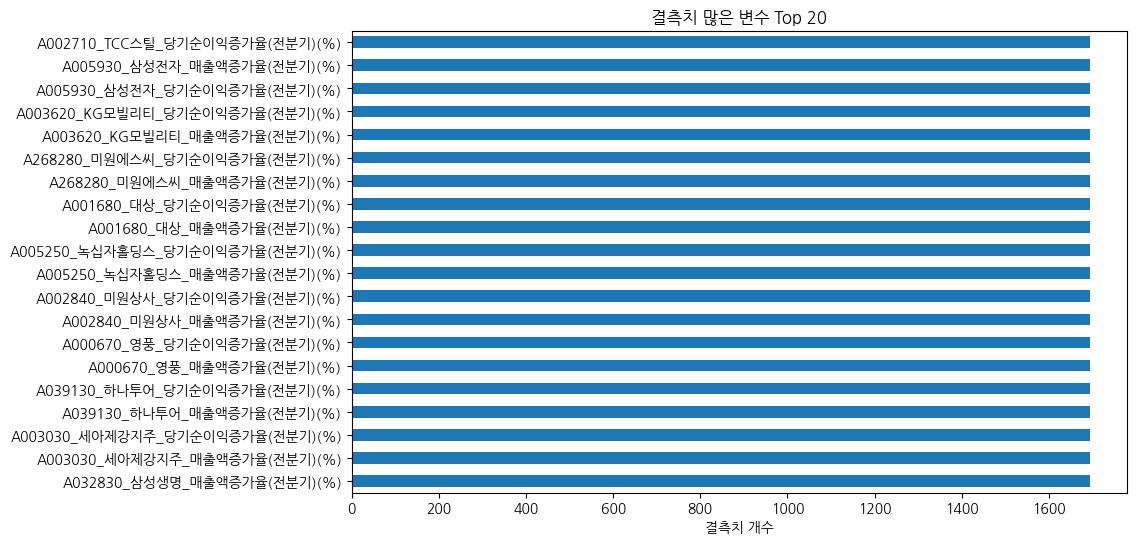

In [43]:
import pandas as pd
import koreanize_matplotlib
import matplotlib.pyplot as plt

# 결측치 개수 계산

null_counts = df_fund.isnull().sum()
top_null_cols = null_counts[null_counts > 0].sort_values(ascending=False).head(20)

# 막대그래프로 보기
top_null_cols.plot(kind="barh", figsize=(10, 6), title="결측치 많은 변수 Top 20")
plt.xlabel("결측치 개수")
plt.gca().invert_yaxis()
plt.show()

In [44]:
# "당기순이익증가율" 또는 "매출액증가율"이 이름에 포함된 열 필터링
drop_cols = [col for col in df_fund.columns
             if "당기순이익증가율" in col or "매출액증가율" in col]

# 제거
df_fund.drop(columns=drop_cols, inplace=True)

# 확인 (선택)
print(f"삭제된 칼럼 수: {len(drop_cols)}")
print("예시:", drop_cols[:5])

삭제된 칼럼 수: 400
예시: ['A005930_삼성전자_매출액증가율(전분기)(%)', 'A005930_삼성전자_당기순이익증가율(전분기)(%)', 'A000660_SK하이닉스_매출액증가율(전분기)(%)', 'A000660_SK하이닉스_당기순이익증가율(전분기)(%)', 'A207940_삼성바이오로직스_매출액증가율(전분기)(%)']


In [45]:
df_fund.isnull().sum()

,0
date,0
A005930_삼성전자_부채비율(%),0
A005930_삼성전자_PER(배),0
A005930_삼성전자_PBR(배),0
A005930_삼성전자_PSR(배),0
...,...
A002710_TCC스틸_PSR(배),0
A002710_TCC스틸_ROA(영업이익)(%),0
A002710_TCC스틸_ROE(당기순이익)(%),0
A002710_TCC스틸_영업이익률(%),0


In [46]:
df_fund.to_csv('fund_factor.csv')

In [47]:
def melt_and_split(df, name="df"):
    # 1. id_vars: date
    value_cols = [col for col in df.columns if col != "date"]

    # 2. melt
    df_long = df.melt(id_vars="date", value_vars=value_cols,
                      var_name="ticker_factor", value_name="value")

    # 3. 종목코드 + 지표 분리
    df_long[["ticker", "factor"]] = df_long["ticker_factor"].str.extract(r"(A\d{6})_(.+)")

    # 4. 피벗 → date, ticker 기준으로 다시 wide로
    df_pivot = df_long.pivot(index=["date", "ticker"], columns="factor", values="value").reset_index()

    print(f"[{name}] shape after processing:", df_pivot.shape)
    return df_pivot

In [49]:
# 1. 날짜 컬럼 정리
for df in [df_fund, df_tech, df_vol]:
    df.rename(columns={df.columns[0]: "date"}, inplace=True)
    df["date"] = pd.to_datetime(df["date"])

# 2. 날짜 기준으로 outer join (열방향으로 붙임)
df_merged = df_fund.merge(df_tech, on="date", how="outer") \
                   .merge(df_vol,  on="date", how="outer")

# 3. 정렬 및 저장
df_merged = df_merged.sort_values("date").reset_index(drop=True)
df_merged.to_csv("merged.csv", index=False)

In [50]:
print("원본 DataFrames:")
print(f"df_fund  → 칼럼 수: {df_fund.shape[1]:>4}, 행 수: {df_fund.shape[0]:>6}")
print(f"df_tech  → 칼럼 수: {df_tech.shape[1]:>4}, 행 수: {df_tech.shape[0]:>6}")
print(f"df_vol   → 칼럼 수: {df_vol.shape[1]:>4}, 행 수: {df_vol.shape[0]:>6}")

원본 DataFrames:
df_fund  → 칼럼 수: 1601, 행 수:   1694
df_tech  → 칼럼 수: 2801, 행 수:    731
df_vol   → 칼럼 수: 1015, 행 수:   1694


In [52]:
print("\n✅ 최종 병합된 df_merged:")
print(f"merged     → 칼럼 수: {df_merged.shape[1]:>4}, 행 수: {df_merged.shape[0]:>6}")


✅ 최종 병합된 df_merged:
merged     → 칼럼 수: 5415, 행 수:   1694


In [53]:
df_tech = pd.read_csv("/content/technical_indicators_kospi200.csv")

In [54]:
print(f"df_tech  → 칼럼 수: {df_tech.shape[1]:>4}, 행 수: {df_tech.shape[0]:>6}")

df_tech  → 칼럼 수: 3001, 행 수:   1694


In [55]:
import pandas as pd

# 데이터 불러오기
df_tech = pd.read_csv("technical_indicators_kospi200.csv")
df_tech.rename(columns={df_tech.columns[0]: "date"}, inplace=True)
df_tech["date"] = pd.to_datetime(df_tech["date"])

# 채워야 할 칼럼 목록
factor_cols = [col for col in df_tech.columns if col != "date"]

# 유효값으로 앞부분 모두 채우고, 그 이후는 ffill
for col in factor_cols:
    first_valid_idx = df_tech[col].first_valid_index()
    if first_valid_idx is not None:
        first_val = df_tech.loc[first_valid_idx, col]
        # 앞부분 다 채움
        df_tech.loc[:first_valid_idx - 1, col] = first_val
        # 뒷부분 ffill
        df_tech[col] = df_tech[col].ffill()

# 확인
print(f"✅ 결측치 채운 후 df_tech shape: {df_tech.shape}")
print("예시:", df_tech.columns[:5])

✅ 결측치 채운 후 df_tech shape: (1694, 3001)
예시: Index(['date', 'A005930_ret_5d', 'A005930_ret_10d', 'A005930_ret_20d',
       'A005930_ret_60d'],
      dtype='object')


In [57]:
df_tech.to_csv('tech_factor.csv')

In [58]:
df_tech

,date,A005930_ret_5d,A005930_ret_10d,A005930_ret_20d,A005930_ret_60d,A005930_disparity_5d,A005930_disparity_10d,A005930_disparity_20d,A005930_disparity_60d,A005930_macd,...,A002710_disparity_10d,A002710_disparity_20d,A002710_disparity_60d,A002710_macd,A002710_rsi,A002710_willr,A002710_hist_vol,A002710_garch_vol,A002710_volume_ma_ratio,A002710_volume_spike_ratio
0,2019-01-01,-0.015504,0.062016,0.175711,0.169251,0.013072,0.028770,0.104370,0.035503,-168.631197,...,0.000764,0.085214,0.092601,-0.951764,74.431390,-0.000000,0.230596,0.031923,1.074803,0.298543
1,2019-01-02,-0.015504,0.062016,0.175711,0.169251,0.013072,0.028770,0.104370,0.035503,-168.631197,...,0.000764,0.085214,0.092601,-0.951764,74.431390,-0.000000,0.230596,0.031923,1.074803,0.298543
2,2019-01-03,-0.015504,0.062016,0.175711,0.169251,0.013072,0.028770,0.104370,0.035503,-168.631197,...,0.000764,0.085214,0.092601,-0.951764,74.431390,-0.000000,0.230596,0.031923,1.074803,0.298543
3,2019-01-04,-0.015504,0.062016,0.175711,0.169251,0.013072,0.028770,0.104370,0.035503,-168.631197,...,0.000764,0.085214,0.092601,-0.951764,74.431390,-0.000000,0.230596,0.031923,1.074803,0.298543
4,2019-01-07,-0.015504,0.062016,0.175711,0.169251,0.013072,0.028770,0.104370,0.035503,-168.631197,...,0.000764,0.085214,0.092601,-0.951764,74.431390,-0.000000,0.230596,0.031923,1.074803,0.298543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1689,2025-06-23,0.013986,-0.030100,0.060329,0.003460,-0.015614,-0.014778,-0.000172,0.028156,-39.008182,...,-0.039486,-0.065376,-0.164737,9.767923,35.577904,-100.000000,0.472534,0.031923,0.979571,1.047985
1690,2025-06-24,0.041308,0.021959,0.122449,0.028912,0.018519,0.025424,0.037024,0.071935,49.908099,...,0.050119,0.020062,-0.082745,102.618895,49.764021,-20.540541,0.568284,0.031923,1.796306,1.693443
1691,2025-06-25,0.025084,0.023372,0.096601,0.042517,0.026801,0.036524,0.045897,0.085308,146.967506,...,0.035159,0.007091,-0.093331,145.597947,47.760746,-34.594595,0.502390,0.031923,0.752955,0.688000
1692,2025-06-26,0.016892,0.011765,0.073084,0.045139,0.005008,0.016720,0.023548,0.065015,122.454324,...,0.044978,0.016352,-0.083596,179.622254,48.869062,-17.791411,0.502430,0.031923,0.809655,0.728487


In [60]:
# 1. 날짜 컬럼 통일 및 형식 확인
for df in [df_fund, df_tech, df_vol]:
    df.rename(columns={df.columns[0]: "date"}, inplace=True)  # Unnamed → date
    df["date"] = pd.to_datetime(df["date"])

# 2. outer 병합 (날짜 기준으로 가로 병합)
df_merged = df_fund.merge(df_tech, on="date", how="outer") \
                   .merge(df_vol,  on="date", how="outer")

# 3. 날짜 정렬 및 인덱스 초기화
df_merged = df_merged.sort_values("date").reset_index(drop=True)

# 4. 저장
df_merged.to_csv("final_merged.csv", index=False)

# 5. 확인
print(f"✅ 병합 완료: 행 수 = {df_merged.shape[0]}, 칼럼 수 = {df_merged.shape[1]}")
print("예시 칼럼:", df_merged.columns[:5])

✅ 병합 완료: 행 수 = 1694, 칼럼 수 = 5615
예시 칼럼: Index(['date', 'A005930_삼성전자_부채비율(%)', 'A005930_삼성전자_PER(배)',
       'A005930_삼성전자_PBR(배)', 'A005930_삼성전자_PSR(배)'],
      dtype='object')


In [59]:
# 병합 전 shape 출력
print("✅ 병합 전 DataFrames:")
print(f"df_fund → 행: {df_fund.shape[0]:>5}, 열: {df_fund.shape[1]:>5}")
print(f"df_tech → 행: {df_tech.shape[0]:>5}, 열: {df_tech.shape[1]:>5}")
print(f"df_vol  → 행: {df_vol.shape[0]:>5}, 열: {df_vol.shape[1]:>5}")

# 병합 후 shape 출력
print("\n✅ 병합 후 df_merged:")
print(f"df_merged → 행: {df_merged.shape[0]:>5}, 열: {df_merged.shape[1]:>5}")

✅ 병합 전 DataFrames:
df_fund → 행:  1694, 열:  1601
df_tech → 행:  1694, 열:  3001
df_vol  → 행:  1694, 열:  1015

✅ 병합 후 df_merged:
df_merged → 행:  1694, 열:  5615
